# Exploratory Data Analysis - Formula 1 Dataset

This notebook explores the EDA (Exploratory Data Analysis) component for the preparation and analysis of a dataset from Formula 1, with the aim of being applied in an unsupervised learning clustering model.

This is a Formula 1 championship dataset containing records from 1950 to 2024, available at: https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020. This dataset contains all Formula 1 information, including races, drivers, constructors (teams), qualifying, circuits, lap times, pit stops, and championships.

### What is Formula 1?

Formula 1 is an international motorsport competition consisting of an annual season of races, called Grands Prix, contested by teams that build their own cars according to technical regulations defined by the FIA. Each event awards points to drivers and teams, which count towards two separate championships: Drivers' and Constructors'. The cars used are high-performance single-seaters, designed to maximize speed, aerodynamics, and efficiency.

### What the dataset contains

The dataset consists of several csv files (circuits, races, results, lap times, pit stops, etc.). Each record may contain IDs for linking data for greater context. In this notebook, we focus on the primary use of four files:

- ``` results.csv```: Contains race results for all participating drivers.

- ``` sprints_results.csv ```: The same format as results, but for sprint races.

- ``` qualifiying.csv  ```: The result of the qualifying sessions that decide the starting position in races.

- ```drivers.csv```: General and demographic information about the drivers.

We can find data such as:

- ```grid```: Driver's starting position.
- ```position```: Position where the driver finished the race.
- ```points```: How many points the driver earned in the race.
- ```laps```: Laps completed by the driver.
- ```milliseconds```: The time the driver took to finish the race (in milliseconds).
- ```fastestLap```: Lap number of the driver's fastest lap.
- ```fastestLapTime```: Time of the fastest lap.
- ```fastestLapSpeed```: Maximum speed of the driver on their fastest lap.
- ```statusId```: Category of the driver's final status: (Ex: 1. Finished Normally, 4. Did not finish, etc...).
- ```q1, q2, q3```: Times from qualifying sessions.

With this data, we can get an initial view of the drivers' historical performance.

### Objective of this Notebook and the Dataset

The ultimate goal is to apply clustering techniques (such as K-Means) to find useful, previously unknown patterns related to driver performance and profiles. To this end, this notebook uses EDA techniques to select, clean, filter, and explore data viability. In other words, this process serves to process and ensure that the data is structured and minimally designed to feed the KMeans model.

### What can be found in this notebook
- **Data Import:** Loading data relevant for analysis.
- **Variable Description and Selection:** Verification of each table's content, data types, and selection of features of interest.
- **Data Type Conversion:** Handling null data and converting types (e.g., objects to int or float).
- **Univariate Analysis:** Individual analysis of each variable to understand its distribution and detect outliers.
- **Bivariate Analysis:** Visualizations and summary statistics to evaluate the relationship (correlation) between dataset variables.
- **Feature Engineering:** Transformation and creation of new variables from existing data to extract more information and, when necessary, reduce dimensionality or complexity for the model.


## Import Libraries

In this segment, the Python libraries and modules necessary for this Notebook are imported.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import os

## Load Data

In this part of the notebook, paths are defined and files are loaded. Next, initial filtering is performed to keep only data from 2022 to 2024. This time window was chosen due to the change in Formula 1 regulations in 2022, which significantly changed the aerodynamics and behavior of the cars.

In [45]:
races_path = '../data/raw/f1_dataset/races.csv'
results_path = '../data/raw/f1_dataset/results.csv'
drivers_path = '../data/raw/f1_dataset/drivers.csv'
constructors_path = '../data/raw/f1_dataset/constructors.csv'
sprints_path = '../data/raw/f1_dataset/sprint_results.csv'
qualifying_path = '../data/raw/f1_dataset/qualifying.csv'
circuits_path = '../data/raw/f1_dataset/circuits.csv'

# Load races dataframe
races_df = pd.read_csv(races_path)
# Filter races for years 2022 to present
races_2024 = races_df[races_df['year'] >= 2022]
races_2024.reset_index(drop=True, inplace=True)
# Get the list of race IDs for the filtered period
race_ids = races_2024['raceId'].unique()

# Load results dataframe
results_df = pd.read_csv(results_path)
# Filter results based on the race IDs
results_2024 = results_df[results_df['raceId'].isin(race_ids)]
results_2024.reset_index(drop=True, inplace=True)
# Load drivers and constructors for 2022-Present
drivers_2024 = results_2024['driverId'].unique()
constructors_2024 = results_2024['constructorId'].unique()

# Load sprints and qualifying for 2022-Present
sprints_df = pd.read_csv(sprints_path)
qualifying_df = pd.read_csv(qualifying_path)
sprints_2024 = sprints_df[sprints_df['raceId'].isin(race_ids)]
sprints_2024.reset_index(drop=True, inplace=True)
qualifying_2024 = qualifying_df[qualifying_df['raceId'].isin(race_ids)]
qualifying_2024.reset_index(drop=True, inplace=True)

# Load additional context dataframes (no filtering needed usually)
constructors_df = pd.read_csv(constructors_path)
constructors_2024_df = constructors_df[constructors_df['constructorId'].isin(constructors_2024)]
constructors_2024_df.reset_index(drop=True, inplace=True)

circuits_df = pd.read_csv(circuits_path)
circuits_2024_df = circuits_df[circuits_df['circuitId'].isin(races_2024['circuitId'].unique())]
circuits_2024_df.reset_index(drop=True, inplace=True)

drivers_df = pd.read_csv(drivers_path)
drivers_2024_df = drivers_df[drivers_df['driverId'].isin(drivers_2024)]
drivers_2024_df.reset_index(drop=True, inplace=True)


# Display the first few rows and shapes to verify
print("Races (2022-2024) Shape:", races_2024.shape)
print("Results (2022-2024) Shape:", results_2024.shape)
print("Sprints Results (2022-2024) Shape:", sprints_2024.shape)
print("Qualifying (2022-2024) Shape:", qualifying_2024.shape)
print("Driver (2022-2024) Shape:", drivers_2024.shape)
print("Constructor (2022-2024) Shape:", constructors_2024.shape)
print("Circuits (2022-2024) Shape:", circuits_2024_df.shape)
print("Constructor (2022-2024) Shape:", constructors_2024_df.shape)

Races (2022-2024) Shape: (68, 18)
Results (2022-2024) Shape: (1359, 18)
Sprints Results (2022-2024) Shape: (300, 16)
Qualifying (2022-2024) Shape: (1359, 9)
Driver (2022-2024) Shape: (28,)
Constructor (2022-2024) Shape: (12,)
Circuits (2022-2024) Shape: (25, 9)
Constructor (2022-2024) Shape: (12, 5)


## Variable Description and Selection

Datasets are selected, and an initial data analysis is performed where we can verify variable types, which columns they contain, and the number of records.


In [46]:
results_2024.info()
sprints_2024.info()
qualifying_2024.info()
circuits_2024_df.info()
circuits_2024_df.head()
constructors_2024_df.info()
constructors_2024_df.head()
races_2024.info()
races_2024.head()
drivers_2024_df.info()
drivers_2024_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   resultId         1359 non-null   int64  
 1   raceId           1359 non-null   int64  
 2   driverId         1359 non-null   int64  
 3   constructorId    1359 non-null   int64  
 4   number           1359 non-null   object 
 5   grid             1359 non-null   int64  
 6   position         1359 non-null   object 
 7   positionText     1359 non-null   object 
 8   positionOrder    1359 non-null   int64  
 9   points           1359 non-null   float64
 10  laps             1359 non-null   int64  
 11  time             1359 non-null   object 
 12  milliseconds     1359 non-null   object 
 13  fastestLap       1359 non-null   object 
 14  rank             1359 non-null   object 
 15  fastestLapTime   1359 non-null   object 
 16  fastestLapSpeed  1359 non-null   object 
 17  statusId      

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
2,20,vettel,5,VET,Sebastian,Vettel,1987-07-03,German,http://en.wikipedia.org/wiki/Sebastian_Vettel
3,842,gasly,10,GAS,Pierre,Gasly,1996-02-07,French,http://en.wikipedia.org/wiki/Pierre_Gasly
4,807,hulkenberg,27,HUL,Nico,Hülkenberg,1987-08-19,German,http://en.wikipedia.org/wiki/Nico_H%C3%BClkenberg


After the initial analysis of the 2022-2024 F1 data, we can observe that the datasets are well-structured and contain detailed information about races, results, drivers, constructors, lap times, and pit stops.

The next step is the initial selection of features that contain relevant information to evaluate driver performance.

In [47]:
results_features = ['driverId', 'raceId','constructorId', 'grid', 'positionOrder', 'points', 'laps', 'milliseconds', 'fastestLapTime', 'fastestLapSpeed', 'statusId', 'session_type']
circuits_features = ['circuitId', 'circuitRef', 'alt']
constructors_features = ['constructorId', 'constructorRef']
races_features = ['raceId', 'circuitId']
driver_features = ['driverId', 'driverRef', 'nationality', 'dob']
qualifying_features = ['raceId','driverId', 'q1', 'q2', 'q3']
# Categorize race and sprint sessions
results_df = results_2024.copy()
sprint_df = sprints_2024.copy()
results_df['session_type'] = 'race'
sprint_df['session_type'] = 'sprint'

# Combine race and sprint results into one dataframe
combined_df = pd.concat([results_df, sprint_df], ignore_index=True)
combined_df

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,session_type
0,25406,1074,844,6,16,1,1,1,1,26.0,57,1:37:33.584,5853584,51,1,1:34.570,206.018,1,race
1,25407,1074,832,6,55,3,2,2,2,18.0,57,+5.598,5859182,52,3,1:35.740,203.501,1,race
2,25408,1074,1,131,44,5,3,3,3,15.0,57,+9.675,5863259,53,5,1:36.228,202.469,1,race
3,25409,1074,847,131,63,9,4,4,4,12.0,57,+11.211,5864795,56,6,1:36.302,202.313,1,race
4,25410,1074,825,210,20,7,5,5,5,10.0,57,+14.754,5868338,53,8,1:36.623,201.641,1,race
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,356,1143,859,215,30,10,16,16,16,0.0,19,+34.356,1657366,18,NaN,1:25.762,NaN,1,sprint
1655,357,1143,852,215,22,16,17,17,17,0.0,19,+35.102,1658112,17,NaN,1:25.838,NaN,1,sprint
1656,358,1143,861,3,43,0,18,18,18,0.0,19,+35.639,1658649,18,NaN,1:25.599,NaN,1,sprint
1657,359,1143,855,15,24,18,19,19,19,0.0,19,+1:11.436,1694446,19,NaN,1:25.051,NaN,1,sprint


In this section, all relevant data is joined into a single dataframe to facilitate data usage:

In [48]:
con1 = pd.merge(combined_df[results_features], races_2024[races_features], on='raceId')
con2 = pd.merge(con1, drivers_2024_df[driver_features], on='driverId')
con3 = pd.merge(con2, constructors_df[constructors_features], on='constructorId')
con4 = pd.merge(con3, circuits_2024_df[circuits_features], on='circuitId')
con5 = pd.merge(con4, qualifying_2024[qualifying_features], on=['raceId', 'driverId'], how='left')
selected_df = con5.drop(['constructorId', 'circuitId', 'driverId'], axis=1) # Remove unnecessary IDs
selected_df.info()
selected_df.head()
selected_df.isna().sum()
selected_df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1659 entries, 0 to 1658
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   raceId           1659 non-null   int64  
 1   grid             1659 non-null   int64  
 2   positionOrder    1659 non-null   int64  
 3   points           1659 non-null   float64
 4   laps             1659 non-null   int64  
 5   milliseconds     1659 non-null   object 
 6   fastestLapTime   1659 non-null   object 
 7   fastestLapSpeed  1359 non-null   object 
 8   statusId         1659 non-null   int64  
 9   session_type     1659 non-null   object 
 10  driverRef        1659 non-null   object 
 11  nationality      1659 non-null   object 
 12  dob              1659 non-null   object 
 13  constructorRef   1659 non-null   object 
 14  circuitRef       1659 non-null   object 
 15  alt              1659 non-null   int64  
 16  q1               1659 non-null   object 
 17  q2            

,count,mean,std,min,25%,50%,75%,max
raceId,1659.0,1110.558770,20.622593,1074.0,1093.0,1112.0,1128.0,1144.0
grid,1659.0,9.921640,5.823283,0.0,5.0,10.0,15.0,20.0
positionOrder,1659.0,10.494274,5.765036,1.0,5.5,10.0,15.0,20.0
points,1659.0,4.500904,6.772663,0.0,0.0,0.0,8.0,26.0
laps,1659.0,48.431585,20.330546,0.0,28.0,55.0,64.0,78.0
statusId,1659.0,7.927667,22.077221,1.0,1.0,1.0,6.0,141.0
alt,1659.0,267.154913,460.831152,-7.0,7.0,45.0,401.0,2227.0


## Data Type Conversion

This section deals with the initial cleaning of the dataset and the standardization of data types to allow for consistent analyses. The main operations include:

- Renaming columns to make the content more readable and coherent.
- Converting values originally stored as text into suitable numeric formats, such as integers or decimals.
- Transforming times in the mm:ss.ms format into milliseconds, allowing for performance calculations and direct comparisons between records.

In [49]:
colnames = {'grid': "start_position", 'positionOrder': 'finish_position', 'milliseconds': 'time_in_mil', 'fastestLapSpeed': 'max_speed_mph'}
selected_df.rename(columns=colnames, inplace=True)
selected_df
cols = ['time_in_mil', 'max_speed_mph']
for i in cols:
    selected_df[i] = pd.to_numeric(selected_df[i], errors='coerce')

selected_df = selected_df.fillna(0) # means the driver was not able to complete the race or did not do the race at all

selected_df

def convert_time(time_str):
    if pd.isna(time_str):
        return 0

    if isinstance(time_str, (int, float, np.integer, np.floating)):
        return int(time_str)

    if isinstance(time_str, str):
        time_str = time_str.strip()
        if time_str in ('', '\\N'):
            return 0
        if ':' not in time_str:
            try:
                return int(float(time_str))
            except ValueError:
                return 0
        try:
            minutes_str, seconds_and_ms_str = time_str.split(':', 1)
            minutes = int(minutes_str)
            seconds_in_ms = float(seconds_and_ms_str) * 1000
            return int(minutes * 60 * 1000 + seconds_in_ms)
        except ValueError:
            return 0

    return 0

selected_df['fastestLapTime'] = selected_df['fastestLapTime'].apply(convert_time)
selected_df['q1'] = selected_df['q1'].apply(convert_time)
selected_df['q2'] = selected_df['q2'].apply(convert_time)
selected_df['q3'] = selected_df['q3'].apply(convert_time)


selected_df.info()
selected_df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1659 entries, 0 to 1658
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   raceId           1659 non-null   int64  
 1   start_position   1659 non-null   int64  
 2   finish_position  1659 non-null   int64  
 3   points           1659 non-null   float64
 4   laps             1659 non-null   int64  
 5   time_in_mil      1659 non-null   float64
 6   fastestLapTime   1659 non-null   int64  
 7   max_speed_mph    1659 non-null   float64
 8   statusId         1659 non-null   int64  
 9   session_type     1659 non-null   object 
 10  driverRef        1659 non-null   object 
 11  nationality      1659 non-null   object 
 12  dob              1659 non-null   object 
 13  constructorRef   1659 non-null   object 
 14  circuitRef       1659 non-null   object 
 15  alt              1659 non-null   int64  
 16  q1               1659 non-null   int64  
 17  q2            

,count,mean,std,min,25%,50%,75%,max
raceId,1659.0,1.110559e+03,2.062259e+01,1074.0,1093.0000,1112.00,1128.000,1144.0
start_position,1659.0,9.921640e+00,5.823283e+00,0.0,5.0000,10.00,15.000,20.0
finish_position,1659.0,1.049427e+01,5.765036e+00,1.0,5.5000,10.00,15.000,20.0
points,1659.0,4.500904e+00,6.772663e+00,0.0,0.0000,0.00,8.000,26.0
laps,1659.0,4.843159e+01,2.033055e+01,0.0,28.0000,55.00,64.000,78.0
time_in_mil,1659.0,3.369675e+06,2.858888e+06,0.0,0.0000,4534875.00,5656050.500,11012095.0
fastestLapTime,1659.0,8.498521e+04,2.119816e+04,0.0,77504.0000,86361.00,97106.000,125585.0
max_speed_mph,1659.0,1.648186e+02,8.868135e+01,0.0,166.9465,203.52,221.979,256.1
statusId,1659.0,7.927667e+00,2.207722e+01,1.0,1.0000,1.00,6.000,141.0
alt,1659.0,2.671549e+02,4.608312e+02,-7.0,7.0000,45.00,401.000,2227.0


## Univariate Analysis - Numerical Variables

This section examines each variable individually to understand its distribution, variability, and possible anomalies. The goal is to identify simple patterns that help characterize data behavior, such as extreme values, asymmetries, unexpected concentrations, or differences between categories. This analysis also allows us to validate the integrity of fields, evaluate the need for normalization or transformation, and guide decisions in the subsequent exploration and modeling phases.

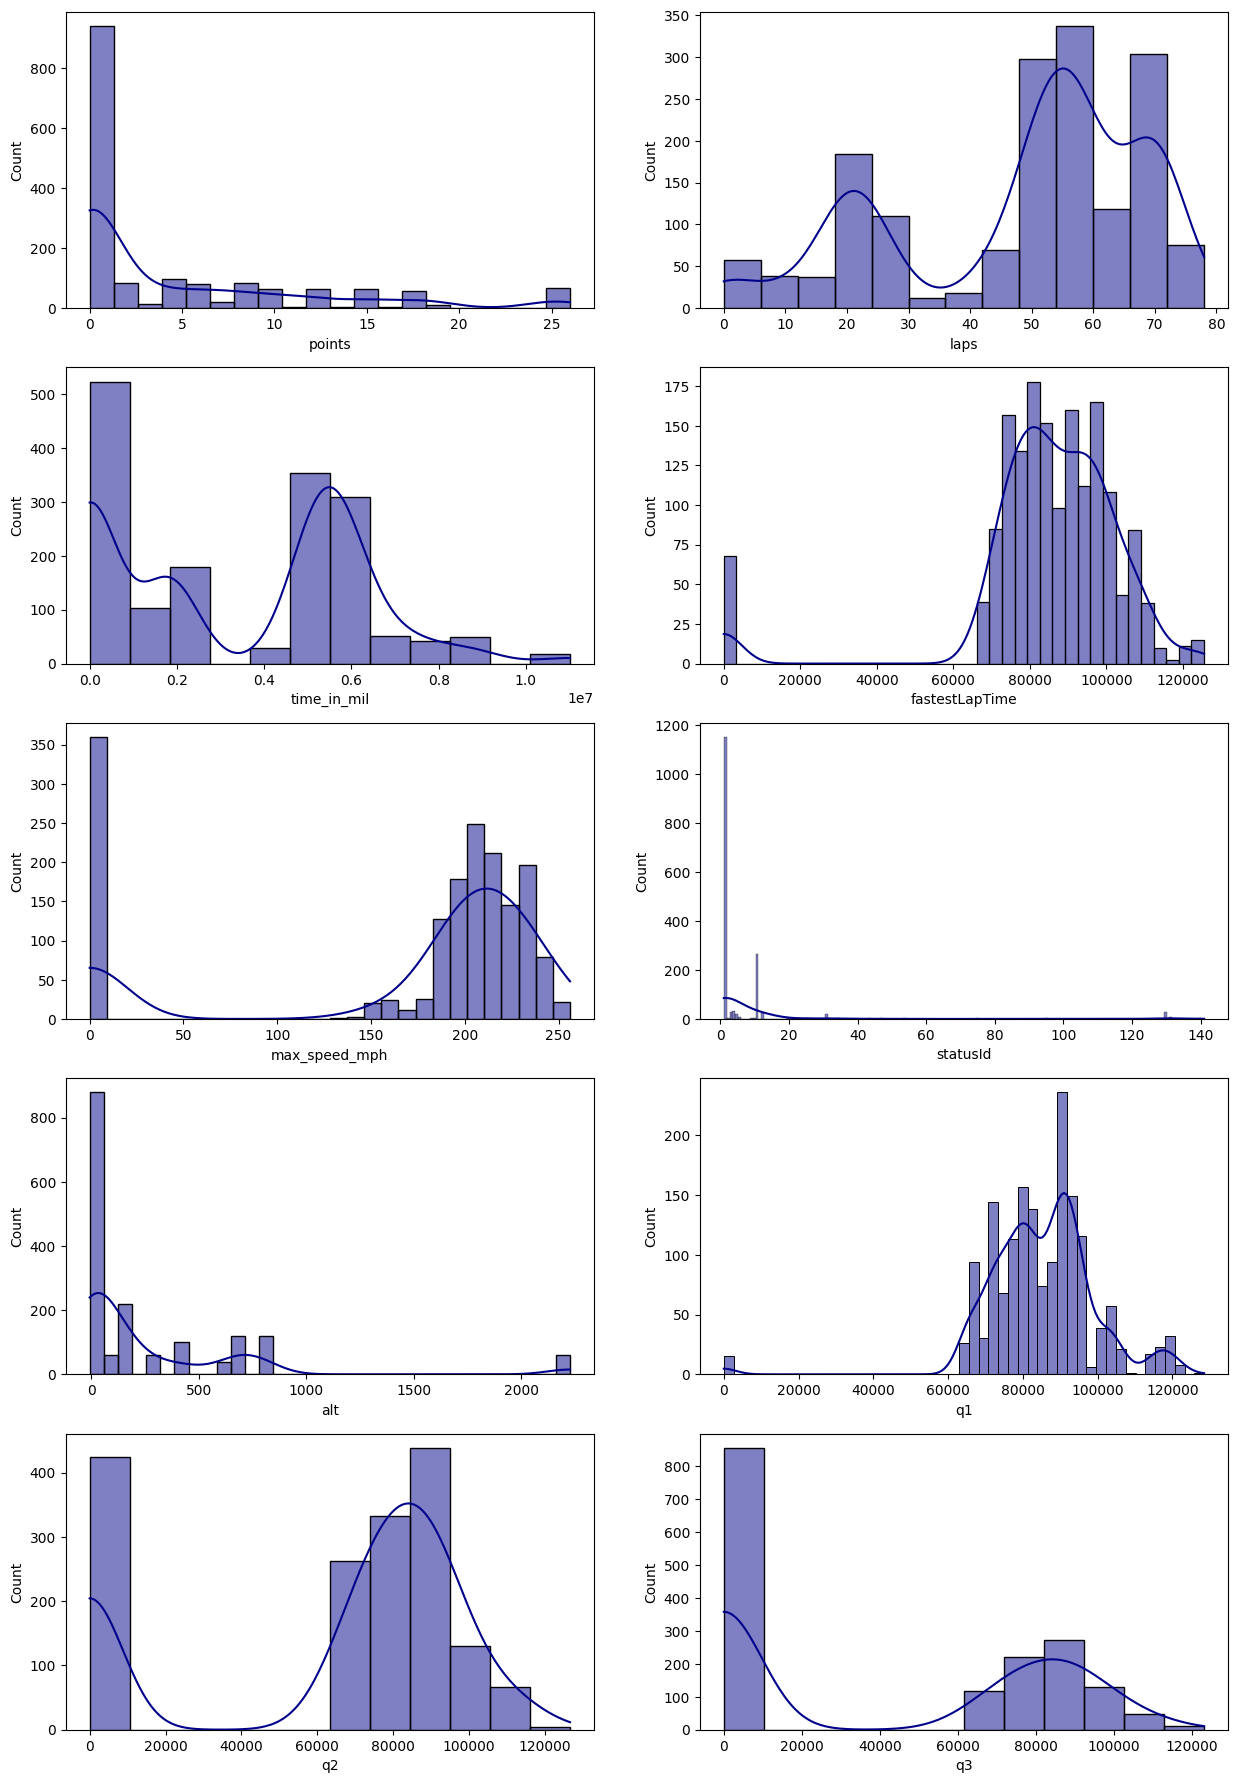

In [50]:
num_features = ['start_position', 'finish_position', 'points', 'laps', 'time_in_mil', 'fastestLapTime', 'max_speed_mph', 'statusId', 'alt', 'q1', 'q2', 'q3']

plt.figure(figsize=(15,50))
for i,j in zip(num_features,range(1,len(num_features)+1)):
    if i in ['start_position', 'finish_position']:
        continue
    plt.subplot(11,2,j)
    sns.histplot(selected_df[i] ,color='darkblue', kde=True)
plt.show()

The distributions show expected patterns in a Formula 1 context. Values equal to zero do not represent outliers; they correspond to drivers who did not complete the race, did not register valid times, or did not advance in qualifying phases.

**points:**

The distributions show expected patterns in a Formula 1 context. Values equal to zero do not represent outliers; they correspond to drivers who did not complete the race, did not register valid times, or did not advance in qualifying phases.

**times_in_mil:** It seems multimodal, with several peaks. This makes sense in a dataset where:

- different tracks have different durations
- total time depends on the number of laps
- varied conditions

**fastestLapTime:**

The distribution is concentrated between about 60k and 100k milliseconds; we can verify that the distribution has an outlier of time 0, which means the driver did not complete a lap to register a time.

**max_speed_mph:**

The histograms indicate groups of different track types:
- slower street circuits
- high-speed circuits like Monza

This is useful for clusters and for understanding performance by track type.

**statusId:**

Highly skewed towards low values. It is normal:

- statusId represents the final state of the car (Finished, Accident, Engine, etc).
- The large concentration should be "Finished".

**alt:**

Strongly multimodal, sea-level tracks vs. high-altitude tracks (Mexico) since altitude affects engine power.

**q1, q2, q3:**

The distributions are as expected; the strong outlier tending towards 0 means the driver failed to set a time to pass to the next qualifying session.

In [51]:
data = selected_df['time_in_mil'] < 0.0
data.describe()
data = selected_df['fastestLapTime'] <0.0
data.describe()

count      1659
unique        1
top       False
freq       1659
Name: fastestLapTime, dtype: object

## Bivariate Analysis

Bivariate analysis examines the relationships between pairs of variables to identify patterns of association, dependence, or correlation. In this section, we use correlation matrices and visualizations such as heatmaps to explore how different performance metrics relate to each other and to driver, constructor, and circuit characteristics. The goal is to detect redundant variables, confirm expected relationships (such as qualifying position vs. points), and discover unexpected associations that can inform feature engineering or cluster interpretation.

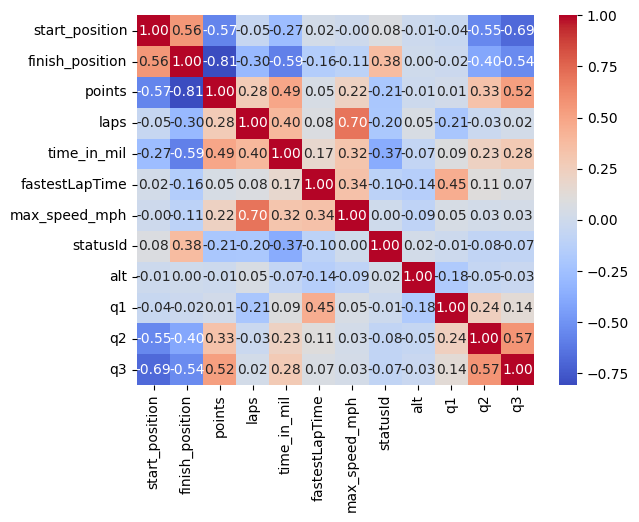

In [52]:
sns.heatmap(selected_df[num_features].corr(), annot = True, fmt = ".2f", cmap='coolwarm')
plt.show()

Analyzing the correlation heatmap, we can verify that certain variables present significant correlations:

- **start_position vs finish_position**: These variables have a strong correlation. To better capture driver performance, we create a new feature ``position_delta`` (start_position - finish_position) representing the gain or loss of positions during the race.

- **time_in_mil vs points**: Despite the high correlation, we choose to keep both columns, as each provides complementary information about driver performance. Total time reflects the complete execution of the race, while points represent the final result.

- **q3 vs points**: There is a significant correlation, as drivers who qualify in the top 10 (Q3) tend to maintain competitive positions until the end of the race. However, we keep both variables as they contain distinct information relevant to the model: qualifying represents performance under ideal conditions, while points reflect the complete race result.

- **q1 vs fastestLapTime**: The correlation is expected, as in qualifying, teams extract maximum performance from cars in clean track conditions without traffic. In races, with 20 drivers simultaneously on track, conditions are different. Both metrics are maintained as they represent distinct performance contexts.

- **max_speed_mph vs laps**: Despite the observed correlation, these variables capture different aspects of performance and circuit characteristics, so they are kept in the analysis.

In summary, we opt for a conservative approach in eliminating features, preserving variables that, despite being correlated, can provide complementary information for identifying patterns in clustering.

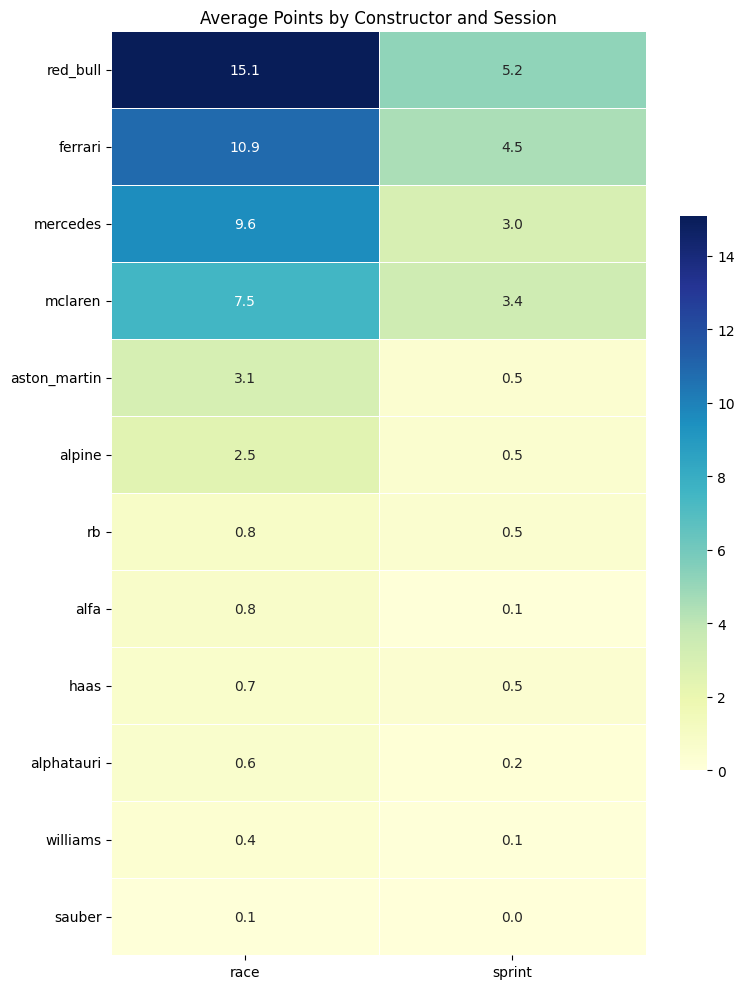

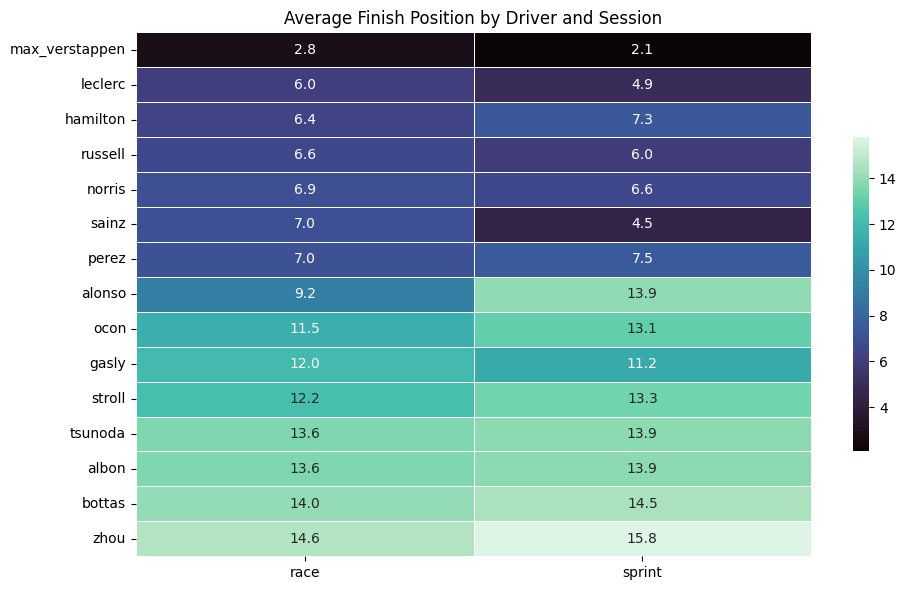

In [53]:
# Mean points by constructor/session heatmap
points_by_constructor = (
    selected_df.pivot_table(values="points", index="constructorRef", columns="session_type", aggfunc="mean")
    .sort_values("race", ascending=False)
)
plt.figure(figsize=(8, 10))
sns.heatmap(points_by_constructor, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.5, cbar_kws={"shrink": 0.6})
plt.title("Average Points by Constructor and Session")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

# Mean finish position by driver/session (top 15 drivers by race count)
top_drivers = (
    selected_df[selected_df["session_type"] == "race"]
    .groupby("driverRef")
    .size()
    .nlargest(15)
    .index
)
finish_by_driver = (
    selected_df[selected_df["driverRef"].isin(top_drivers)]
    .pivot_table(values="finish_position", index="driverRef", columns="session_type", aggfunc="mean")
    .sort_values("race", ascending=True)
)

plt.figure(figsize=(10, 6))
sns.heatmap(finish_by_driver, annot=True, fmt=".1f", cmap="mako", linewidths=0.5, cbar_kws={"shrink": 0.6})
plt.title("Average Finish Position by Driver and Session")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

## Feature Engineering

In this section, new variables derived from existing data are created to capture more relevant information about driver performance:

### New Features Created:

**position_delta:**
- Calculated as ``start_position - finish_position``
- Represents the gain or loss of positions during the race
- Positive values indicate the driver gained positions; negative values indicate loss of positions
- Replaces original start and finish position variables, reducing correlation and better capturing relative performance

**pace:**
- Calculated as `time_in_mil / laps`
- Represents the average time per lap in milliseconds
- Allows comparing consistency and average speed of drivers regardless of the number of laps completed
- Useful for normalizing performance across different circuits and race conditions

**age:**
- Calculated from the driver's date of birth (``dob``) and the race date
- Represents the driver's age at the time of each race
- Allows analyzing if age influences performance patterns and identifying age profiles in clusters

**One-Hot Encoding e Label Encoding:**

- **session_type**: One-Hot Encoding applied to convert the categorical variable (race/sprint) into binary format. The first category is dropped (``drop_first=True``) to avoid multicollinearity.

- **nationality**: Label Encoding applied to transform driver nationalities into numeric values. This approach is suitable as it allows the clustering model to consider driver origin without creating excessive dimensionality.

- **Variáveis categóricas textuais**: Reference columns (driverRef, constructorRef, circuitRef) are kept in the dataset for contextualization and interpretation of results, positioned at the end of the dataframe after numerical variables.

These transformations aim to reduce dimensionality, eliminate redundancies, and create more interpretable metrics that better capture real driver performance for application in the clustering model.


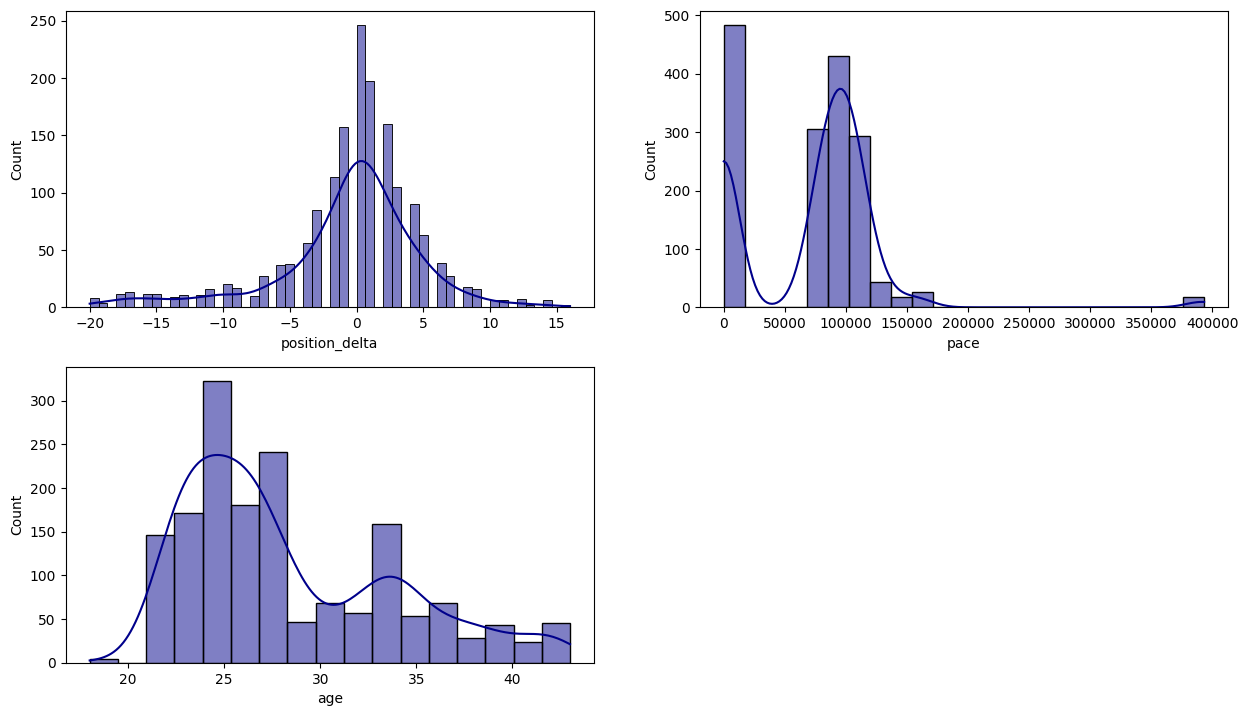

In [54]:
selected_df = selected_df.copy()
selected_df['position_delta'] = selected_df['start_position'] - selected_df['finish_position']
selected_df = selected_df.drop(columns=['start_position', 'finish_position'])
selected_df.head()
selected_df['position_delta'].describe()
selected_df = selected_df.copy()
selected_df['pace'] = selected_df['time_in_mil'] // selected_df['laps']
selected_df.head()
selected_df['pace'].describe()
race_dates = races_2024.set_index('raceId')['date']

selected_df['age'] = (
    (
        pd.to_datetime(selected_df['raceId'].map(race_dates), errors='coerce')
        - pd.to_datetime(selected_df['dob'], errors='coerce')
    )
    .dt.days.floordiv(365)
).astype('Int64')

selected_df[['driverRef', 'age']].head()
selected_df = selected_df.drop(columns=['dob'])
selected_df['age'].describe()
selected_df.describe().T
feature_r = ['position_delta', 'pace', 'age']
plt.figure(figsize=(15,50))
for i,j in zip(feature_r,range(1,len(feature_r)+1)):
    plt.subplot(11,2,j)
    sns.histplot(selected_df[i] ,color='darkblue', kde=True)
plt.show()

### Analysis of New Features

**position_delta:**

The distribution is approximately normal and centered on zero, indicating that most drivers maintain their starting position or undergo slight changes. The more pronounced tails on the negative side reflect significant position losses, typically caused by accidents, mechanical failures, or less effective strategies. This variable is adequately clean and effectively represents the performance variation among drivers during the race.

**pace:**

The distribution is approximately normal and centered on zero, indicating that most drivers maintain their starting position or undergo slight changes. The more pronounced tails on the negative side reflect significant position losses, typically caused by accidents, mechanical failures, or less effective strategies. This variable is adequately clean and effectively represents the performance variation among drivers during the race.

**age:**

The distribution reveals two main age groups: young drivers (between 23 and 27 years old) and more experienced drivers (over 30 years old). This distribution is natural and consistent with the reality of Formula 1.

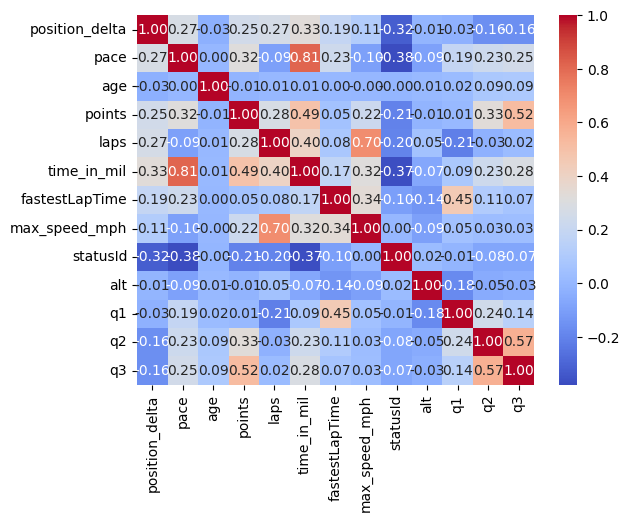

,raceId,points,laps,time_in_mil,fastestLapTime,max_speed_mph,statusId,nationality,alt,q1,q2,q3,position_delta,pace,age,session_type_sprint,driverRef,constructorRef,circuitRef
0,1074,26.0,57,5853584.0,94570,206.018,1,13,7,91471,90932,90558,0,102694.0,24,False,leclerc,ferrari,bahrain
1,1074,18.0,57,5859182.0,95740,203.501,1,15,7,91567,90787,90687,1,102792.0,27,False,sainz,ferrari,bahrain
2,1074,15.0,57,5863259.0,96228,202.469,1,3,7,92285,91048,91238,2,102864.0,37,False,hamilton,mercedes,bahrain
3,1074,12.0,57,5864795.0,96302,202.313,1,3,7,92269,91252,92216,5,102891.0,24,False,russell,mercedes,bahrain
4,1074,10.0,57,5868338.0,96623,201.641,1,6,7,91955,91461,91808,2,102953.0,29,False,kevin_magnussen,haas,bahrain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,1143,0.0,19,1657366.0,85762,0.000,1,14,12,82411,0,0,-6,87229.0,22,True,lawson,rb,losail
1655,1143,0.0,19,1658112.0,85838,0.000,1,11,12,82364,81771,0,-1,87269.0,24,True,tsunoda,rb,losail
1656,1143,0.0,19,1658649.0,85599,0.000,1,1,12,82594,0,0,-18,87297.0,21,True,colapinto,williams,losail
1657,1143,0.0,19,1694446.0,85051,0.000,1,5,12,82103,81501,0,-1,89181.0,25,True,zhou,sauber,losail


In [55]:
feature_all = ['position_delta', 'pace', 'age'] + num_features[2:]
sns.heatmap(selected_df[feature_all].corr(), annot = True, fmt = ".2f", cmap='coolwarm')
plt.show()
selected_df = pd.get_dummies(selected_df, columns=['session_type'], drop_first=True)
encoder = LabelEncoder()
selected_df["nationality"] = encoder.fit_transform(selected_df["nationality"])
selected_df
object_cols = selected_df.select_dtypes(include=['object']).columns
num_features = selected_df.select_dtypes(include=['int64', 'float64', 'Int64', 'bool']).columns

ordered_cols = list(num_features) + list(object_cols)
selected_df = selected_df.loc[:, ordered_cols]
selected_df.isna().sum()
pace_mean = selected_df['pace'].mean(skipna=True)
selected_df['pace'] = selected_df['pace'].fillna(pace_mean)
selected_df

## Export Processed Dataset

After completing all cleaning, transformation, and feature engineering steps, the processed dataset is ready to be exported and used in the clustering modeling phase.

The file will be saved in CSV format in the ``data/processed/`` directory named ``f1_processed_clustering.csv``, containing all numerical and encoded categorical variables that will be used as input for the K-Means algorithm.

In [56]:
path = "../data/processed/f1_processed_clustering.csv"

os.makedirs("data", exist_ok=True)

selected_df.to_csv(path, index=False)

print(f"Processed dataset saved in {path}")

Processed dataset saved in ../data/processed/f1_processed_clustering.csv


## Conclusion

In this notebook, a complete exploratory analysis of the Formula 1 dataset (2022-2024) was performed, focusing on data preparation for clustering. The main steps included:

1. **Loading and Filtering:** We selected data from 2022 onwards, coinciding with the change in technical regulations that significantly altered car behavior.

2. **Data Integration:** We consolidated information from multiple sources (races, sprints, qualifying, drivers, constructors, and circuits) into a single structured dataframe.

3. **Data Treatment:** We converted variables to suitable numeric types, standardized time formats, and handled missing values in a contextualized manner.

4. **Univariate and Bivariate Analysis:** We identified expected distribution patterns, relevant correlations between variables, and validated data integrity.

5. **Feature Engineering:** We created new derived variables (``position_delta``, ``pace``, ``age``) that better capture driver performance, reducing redundancies and increasing interpretability.

6. **Categorical Variable Encoding:** We applied One-Hot Encoding and Label Encoding to prepare the dataset for machine learning algorithms.

The final dataset, exported as ``f1_processed_clustering.csv``, contains clean and normalized numerical variables, ready to feed the K-Means model. This EDA process ensures that the data is structured, consistent, and optimized for identifying performance patterns and driver profiles through unsupervised clustering techniques.